In [41]:
# Importing the necessary libraries for LSTM Model 
import requests, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pandas.core.internals.blocks import soft_convert_objects
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential


                 datetime         open         high          low        close
0     2023-03-25 00:00:00  27493.74023  27495.63086  27464.83984  27495.63086
1     2023-03-25 00:05:00  27480.92969  27495.14062  27468.41016  27475.16992
2     2023-03-25 00:10:00  27484.16992  27493.05078  27458.68945  27493.05078
3     2023-03-25 00:15:00  27491.08984  27538.98047  27491.08984  27507.91016
4     2023-03-25 00:20:00  27505.61914  27505.81055  27492.66992  27499.13086
...                   ...          ...          ...          ...          ...
4892  2023-04-10 23:40:00  29724.01000  29724.01000  29661.91000  29674.26000
4893  2023-04-10 23:45:00  29671.38000  29711.21000  29671.38000  29691.87000
4894  2023-04-10 23:50:00  29691.88000  29696.66000  29610.01000  29630.26000
4895  2023-04-10 23:55:00  29627.40000  29668.83000  29627.40000  29660.41000
4896  2023-04-11 00:00:00  29657.70000  29683.91000  29645.48000  29645.49000

[4897 rows x 5 columns]


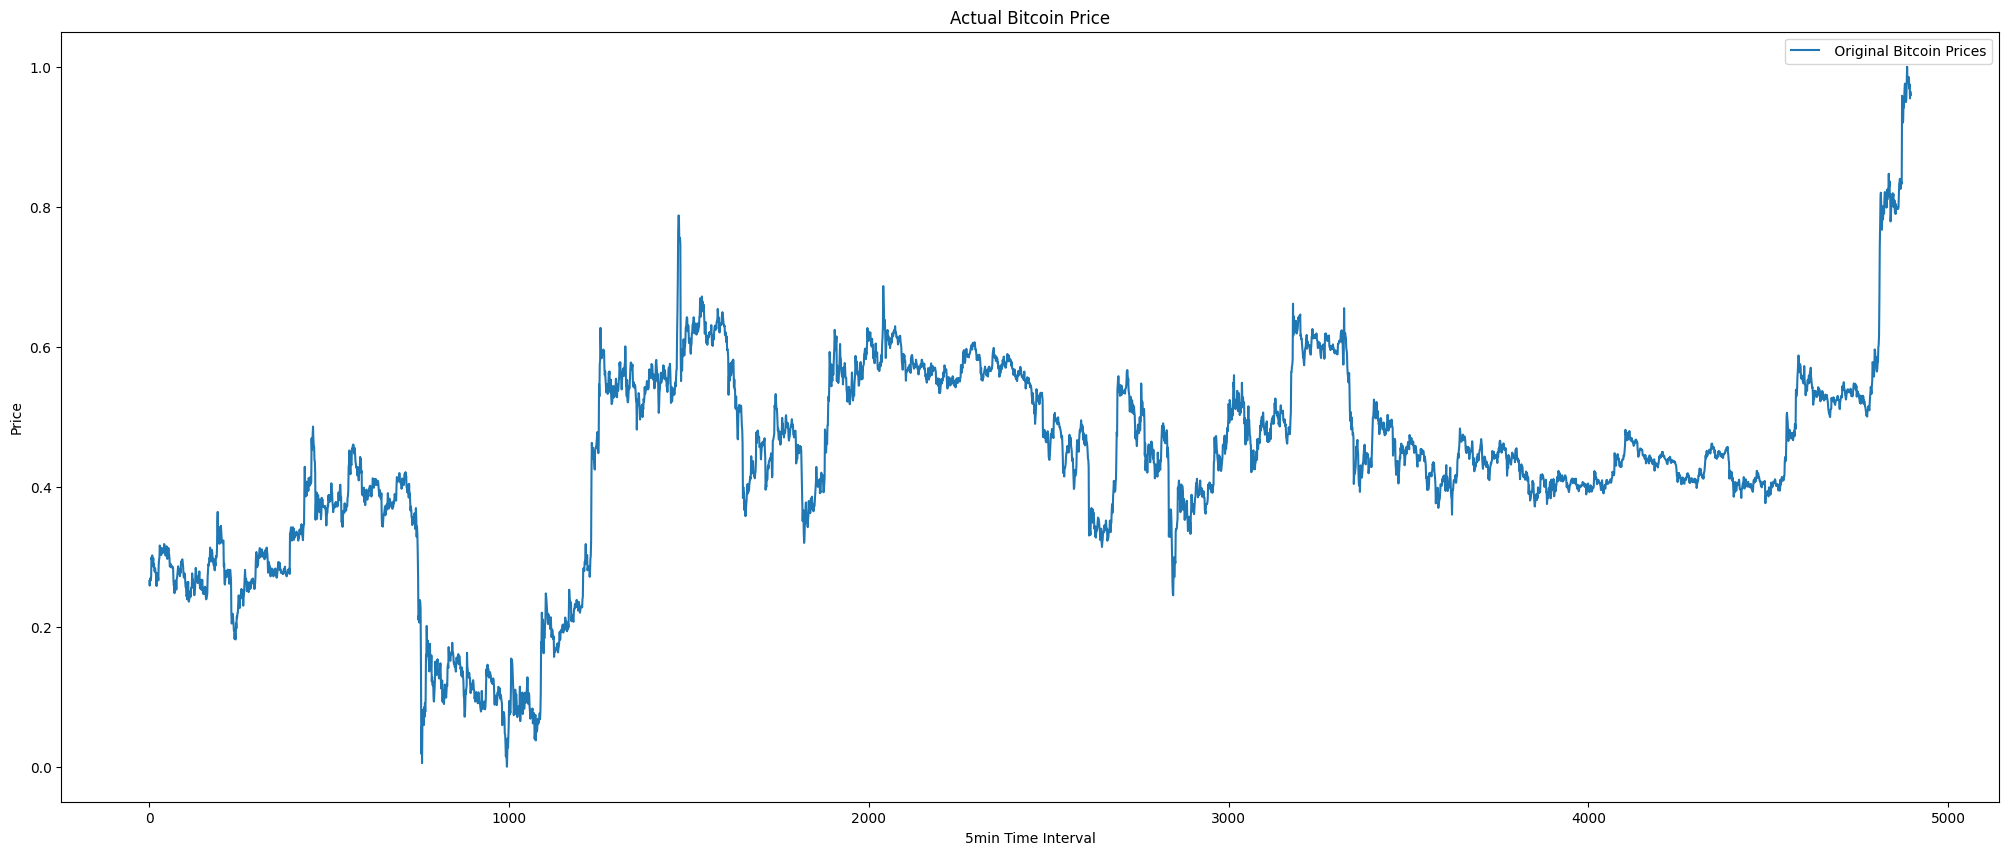

In [44]:
# Setting up a class that can be used for any Model

class Data():
  def __init__(self, api_url):
      self.api_url = api_url
  
  def getting_data(self):
      try:
          data = requests.get(self.api_url).json()
          data_final = pd.DataFrame(data['values'])
          return data_final
      except:
          print("Please check if the Parameters in the url are correct.")
  
  def min_max(self, gd):
      scaler = MinMaxScaler(feature_range=(0,1))
      scaled_data = scaler.fit_transform(gd['close'].values.reshape(-1,1))
      return scaled_data

  def plot_graph(self, data):
      plt.figure(figsize=(25, 10))
      plt.plot(data, label=' Original Bitcoin Prices')
      plt.title('Actual Bitcoin Price')
      plt.xlabel('5min Time Interval')
      plt.ylabel('Price')
      plt.legend()
      plt.show()

# URL parameters
api_key = 'bc815ffa29684289b066eb9f3113c13a'
symbol = 'BTC/USD'
interval = '5min'
order = 'asc'
start_date = '2023-03-25 00:00:00'
end_date = '2023-04-11 00:00:00'
# This is the url of twelve data API 
api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&start_date={start_date}&end_date={end_date}&interval={interval}&order={order}&apikey={api_key}'

## Calling the class object
data = Data(api_url)
gd = data.getting_data()
print(gd)
data.min_max(gd)
data.plot_graph(data.min_max(gd))

Epoch 1/10
76/76 [==============================] - 9s 76ms/step - loss: 0.0123 - accuracy: 4.1144e-04
Epoch 2/10
76/76 [==============================] - 5s 65ms/step - loss: 0.0035 - accuracy: 4.1144e-04
Epoch 3/10
76/76 [==============================] - 5s 65ms/step - loss: 0.0034 - accuracy: 4.1144e-04
Epoch 4/10
76/76 [==============================] - 6s 77ms/step - loss: 0.0031 - accuracy: 4.1144e-04
Epoch 5/10
76/76 [==============================] - 5s 66ms/step - loss: 0.0030 - accuracy: 4.1144e-04
Epoch 6/10
76/76 [==============================] - 6s 76ms/step - loss: 0.0029 - accuracy: 4.1144e-04
Epoch 7/10
76/76 [==============================] - 5s 66ms/step - loss: 0.0028 - accuracy: 4.1144e-04
Epoch 8/10
76/76 [==============================] - 6s 76ms/step - loss: 0.0028 - accuracy: 4.1144e-04
Epoch 9/10
76/76 [==============================] - 5s 66ms/step - loss: 0.0026 - accuracy: 4.1144e-04
Epoch 10/10
76/76 [==============================] - 6s 75ms/step - loss:

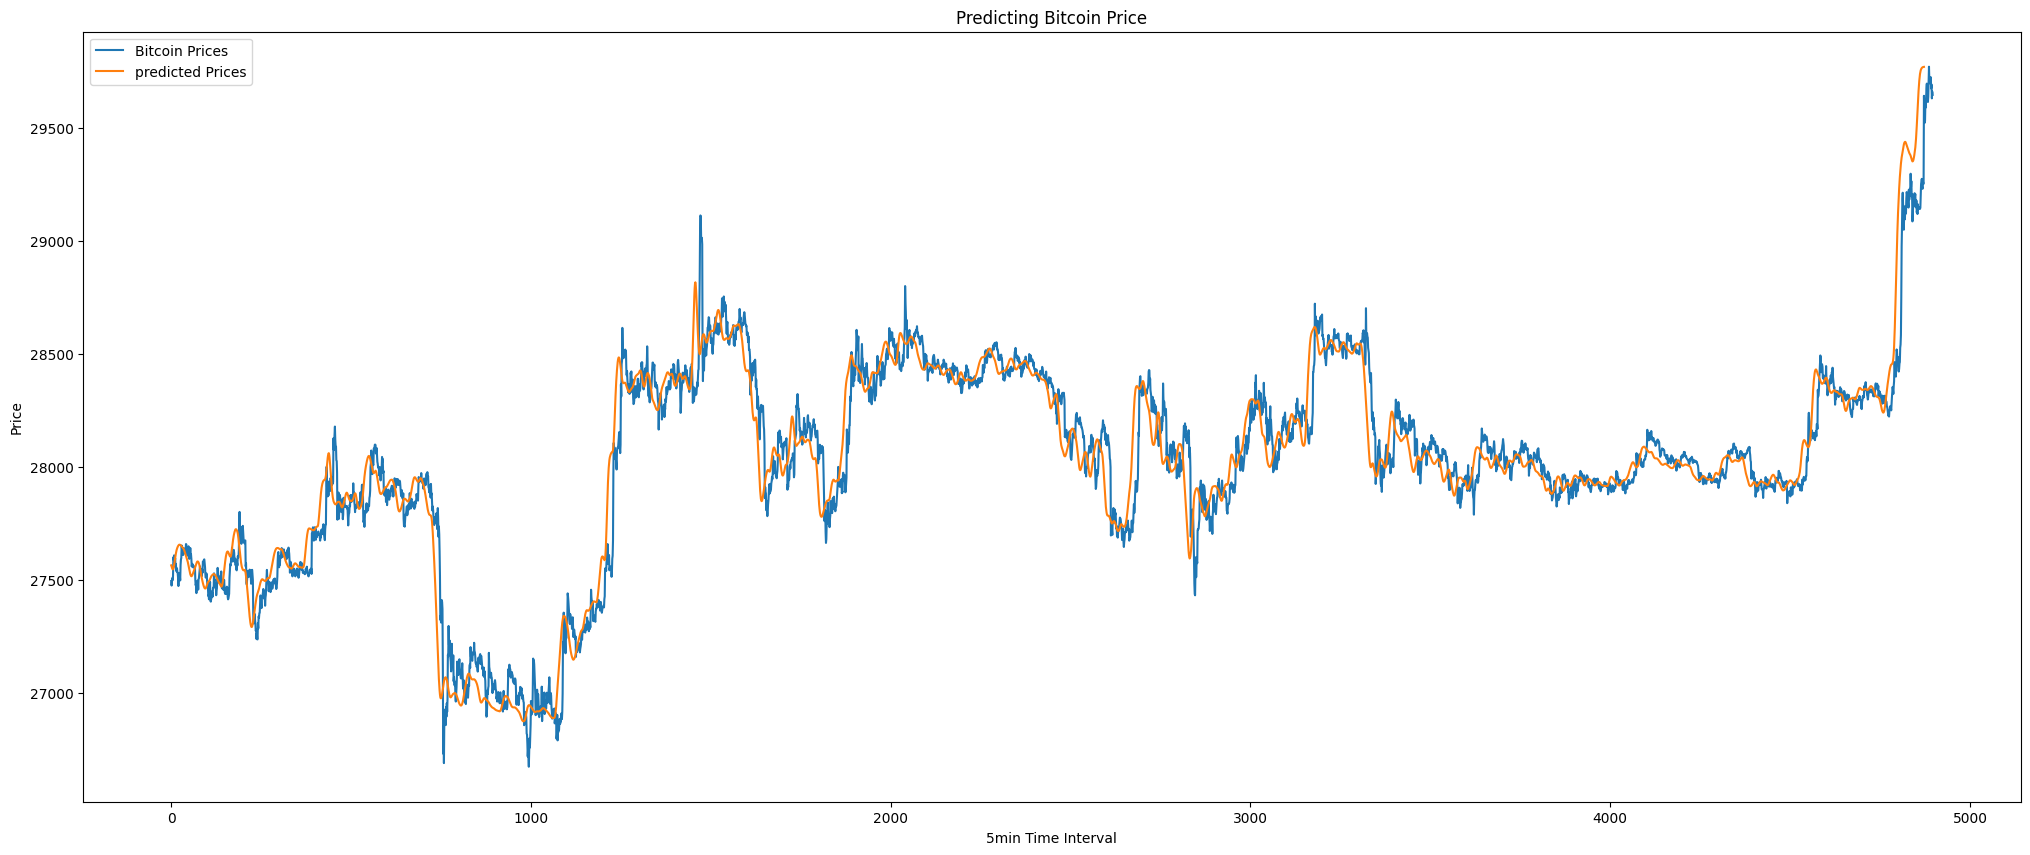

1/1 [==============================] - 0s 27ms/step
The price of Bitcoin in next 5 mins will be  29769.697


In [46]:
#Setting up a training class for the model

class Training(Data):
  def __init__(self, test_api_url, training_interval, prediction_interval):
    super().__init__(api_url)
    self.training_interval = training_interval
    self.prediction_interval = prediction_interval
    self.x_train = []
    self.y_train = []
    self.test_api_url= test_api_url
  
  def prediction(self):
    gd = self.getting_data()
    for i in range(self.training_interval, len(super().min_max(gd))-self.prediction_interval):
        self.x_train.append(super().min_max(gd)[i - self.training_interval: i, 0])
        self.y_train.append(super().min_max(gd)[i + self.prediction_interval, 0])
    self.x_train = np.array(self.x_train)
    self.y_train = np.array(self.y_train)
    self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], self.x_train.shape[1], 1))


  def sequential(self):
    '''Returns the trained LSTM model'''
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(self.x_train.shape[1], 1), activation='relu'))
    model.add(Dropout(0.4))
    model.add(LSTM(64, return_sequences=True, activation='relu'))
    model.add(Dropout(0.3))
    model.add(LSTM(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.fit(self.x_train, self.y_train, epochs=10, batch_size=64)
    return model
  
  def test_data(self):
    try:
      test_data = requests.get(self.test_api_url).json()
    except:
      print("Error while processing the request")
    test_data_final = pd.DataFrame(test_data['values'])    
    self.bitcoin_prices = pd.to_numeric(test_data_final['close'], errors='coerce').values
    test_inputs = test_data_final['close'].values # closing prices
    test_inputs = test_inputs.reshape(-1,1) # reshapin ginto 2 dimensions ot test the data.
    self.scaler = MinMaxScaler(feature_range=(0,1))
    model_inputs = self.scaler.fit_transform(test_inputs) #  model innput will have to squeeze the data between 0 and 1. 
    return model_inputs
  
  def make_x_test(self, td):
    x_test = []
    for x in range(self.training_interval, len(td)):
        x_test.append(td[x - self.training_interval:x, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    print(x_test.shape)
    return x_test  

  def prediction_of_bitcoin_prices(self, td, fitted_data, xtest):       
    # Make predictions using the model
    prediction_prices = fitted_data.predict(xtest)
    prediction_prices = self.scaler.inverse_transform(prediction_prices)
    prediction_prices = prediction_prices.reshape(prediction_prices.shape[0], -1)    
    return prediction_prices

  def plot_graph( self):
    plt.figure(figsize = (25, 10))
    plt.plot(self.bitcoin_prices, label = 'Bitcoin Prices')
    plt.plot(self.prediction_of_bitcoin_prices(td, fitted_data, xtest), label = 'predicted Prices')
    plt.title('Predicting Bitcoin Price')
    plt.xlabel('5min Time Interval')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

  def predict_next_hour_price(self, fitted_data, td):
    last_data = td[len(td) - self.training_interval:len(td), 0]
    last_data = np.array(last_data)
    last_data = np.reshape(last_data, (1, last_data.shape[0], 1))
    prediction = fitted_data.predict(last_data)
    prediction = self.scaler.inverse_transform(prediction)
    print("The price of Bitcoin in next 5 mins will be ", prediction[0][0])

# setting up the parameters for the class
test_start = '2023-04-11 00:00:00'
test_end = '2023-04-14 00:00:00'
test_api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&start_date={test_start}&end_date={test_end}&interval={interval}&order={order}&apikey={api_key}'

training_interval = 24
prediction_interval = 12

#Class Objects
train = Training(api_url, training_interval,prediction_interval)
train.prediction()
fitted_data = train.sequential()
td = train.test_data()
#print(td)
xtest = train.make_x_test(td)
train.prediction_of_bitcoin_prices(td, fitted_data, xtest)
train.plot_graph()
train.predict_next_hour_price(fitted_data, td)
